# Springboard Logistic Regression Advanced Case Study
$$
\renewcommand{\like}{{\cal L}}
\renewcommand{\loglike}{{\ell}}
\renewcommand{\err}{{\cal E}}
\renewcommand{\dat}{{\cal D}}
\renewcommand{\hyp}{{\cal H}}
\renewcommand{\Ex}[2]{E_{#1}[#2]}
\renewcommand{\x}{{\mathbf x}}
\renewcommand{\v}[1]{{\mathbf #1}}
$$

This case study delves into the math behind logistic regression in a Python environment. We've adapted this case study from [Lab 5 in the CS109](https://github.com/cs109/2015lab5) course. Please feel free to check out the original lab, both for more exercises, as well as solutions.

We turn our attention to **classification**. Classification tries to predict, which of a small set of classes, an observation belongs to. Mathematically, the aim is to find $y$, a **label** based on knowing a feature vector $\x$. For instance, consider predicting gender from seeing a person's face, something we do fairly well as humans. To have a machine do this well, we would typically feed the machine a bunch of images of people which have been labelled "male" or "female" (the training set), and have it learn the gender of the person in the image from the labels and the *features* used to determine gender. Then, given a new photo, the trained algorithm returns us the gender of the person in the photo.

There are different ways of making classifications. One idea is shown schematically in the image below, where we find a line that divides "things" of two different types in a 2-dimensional feature space. The classification show in the figure below is an example of a maximum-margin classifier where construct a decision boundary that is far as possible away from both classes of points. The fact that a line can be drawn to separate the two classes makes the problem *linearly separable*. Support Vector Machines (SVM) are an example of a maximum-margin classifier.

<img src="images/onelinesplit.png" width="400" height="200">

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import sklearn.model_selection

c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, 
                cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, 
               s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, 
               alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, 
                     cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, 
                           colorscale=colorscale, cdiscrete=cdiscrete, 
                           psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    #plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

## A Motivating Example Using `sklearn`: Heights and Weights

We'll use a dataset of heights and weights of males and females to hone our understanding of classifiers. We load the data into a dataframe and plot it.

In [2]:
dflog = pd.read_csv("data/01_heights_weights_genders.csv")
dflog.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


Remember that the form of data we will use always is

<img src="images/dataform.jpg" width="400" height="200">

with the "response" or "label" $y$ as a plain array of 0s and 1s for binary classification. Sometimes we will also see -1 and +1 instead. There are also *multiclass* classifiers that can assign an observation to one of $K > 2$ classes and the label may then be an integer, but we will not be discussing those here.

`y = [1,1,0,0,0,1,0,1,0....]`.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<ul>
  <li> <b>Exercise:</b> Create a scatter plot of Weight vs. Height
  <li> <b>Exercise:</b> Color the points differently by Gender
</ul>
</div>

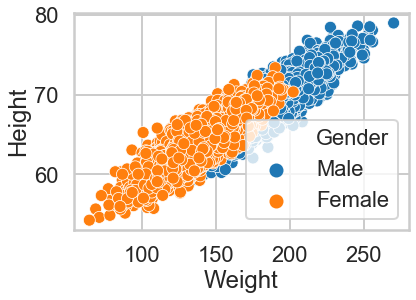

In [15]:
# your turn
sns.scatterplot(x='Weight', y='Height', data=dflog, hue='Gender')
plt.xlabel('Weight')
plt.ylabel('Height')
plt.show()


### Training and Test Datasets

When fitting models, we would like to ensure two things:

* We have found the best model (in terms of model parameters).
* The model is highly likely to generalize i.e. perform well on unseen data.

<br/>
<div class="span5 alert alert-success">
<h4>Purpose of splitting data into Training/testing sets</h4>
<ul>
  <li> We built our model with the requirement that the model fit the data well. </li>
  <li> As a side-effect, the model will fit <b>THIS</b> dataset well. What about new data? </li>
    <ul>
      <li> We wanted the model for predictions, right?</li>
    </ul>
  <li> One simple solution, leave out some data (for <b>testing</b>) and <b>train</b> the model on the rest </li>
  <li> This also leads directly to the idea of cross-validation, next section. </li>  
</ul>
</div>

First, we try a basic Logistic Regression:

* Split the data into a training and test (hold-out) set
* Train on the training set, and test for accuracy on the testing set

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split the data into a training and test set.
Xlr, Xtestlr, ylr, ytestlr = train_test_split(dflog[['Height','Weight']].values, 
                                              (dflog.Gender == "Male").values,random_state=5)

clf = LogisticRegression()
# Fit the model on the trainng data.
clf.fit(Xlr, ylr)
# Print the accuracy from the testing data.
print(accuracy_score(clf.predict(Xtestlr), ytestlr))

0.9252


### Tuning the Model

The model has some hyperparameters we can tune for hopefully better performance. For tuning the parameters of your model, you will use a mix of *cross-validation* and *grid search*. In Logistic Regression, the most important parameter to tune is the *regularization parameter* `C`. Note that the regularization parameter is not always part of the logistic regression model. 

The regularization parameter is used to control for unlikely high regression coefficients, and in other cases can be used when data is sparse, as a method of feature selection.

You will now implement some code to perform model tuning and selecting the regularization parameter $C$.

We use the following `cv_score` function to perform K-fold cross-validation and apply a scoring function to each test fold. In this incarnation we use accuracy score as the default scoring function.

In [17]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

Below is an example of using the `cv_score` function for a basic logistic regression model without regularization.

In [18]:
clf = LogisticRegression()
score = cv_score(clf, Xlr, ylr)
print(score)

0.9172


<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<b>Exercise:</b> Implement the following search procedure to find a good model
<ul>
<li> You are given a list of possible values of `C` below
<li> For each C:
  <ol>
  <li> Create a logistic regression model with that value of C
  <li> Find the average score for this model using the `cv_score` function **only on the training set** `(Xlr, ylr)`
  </ol>
<li> Pick the C with the highest average score
</ul>
Your goal is to find the best model parameters based *only* on the training set, without showing the model test set at all (which is why the test set is also called a *hold-out* set).
</div>

In [38]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100, 50, 1000000, .0000000001]

# your turn
C_scores = {}
for Ci in Cs:
    clft = LogisticRegression(C=Ci)
    score = cv_score(clft, Xlr, ylr)
    C_scores[Ci]=score
C_scores

{0.001: 0.9122666666666668,
 0.1: 0.9172,
 1: 0.9172,
 10: 0.9172,
 100: 0.9172,
 50: 0.9172,
 1000000: 0.9172,
 1e-10: 0.4976}

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>
**Exercise:** Now you want to estimate how this model will predict on unseen data in the following way:
<ol>
<li> Use the C you obtained from the procedure earlier and train a Logistic Regression on the training data
<li> Calculate the accuracy on the test data
</ol>

<p>You may notice that this particular value of `C` may or may not do as well as simply running the default model on a random train-test split. </p>

<ul>
<li> Do you think that's a problem? No as long it is minimally different. Expect some change as it is different data
<li> Why do we need to do this whole cross-validation and grid search stuff anyway? To prevent overfitting
</ul>

</div>

In [40]:
# your turn
clf_C = LogisticRegression(C=1)
clf_C.fit(Xlr, ylr)
clf_C.score(Xtestlr, ytestlr)

0.9252

### Black Box Grid Search in `sklearn`

Scikit-learn, as with many other Python packages, provides utilities to perform common operations so you do not have to do it manually. It is important to understand the mechanics of each operation, but at a certain point, you will want to use the utility instead to save time...

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<b>Exercise:</b> Use scikit-learn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) tool to perform cross validation and grid search. 

* Instead of writing your own loops above to iterate over the model parameters, can you use GridSearchCV to find the best model over the training set? 
* Does it give you the same best value of `C`? Yes
* How does this model you've obtained perform on the test set? Same as above </div>

In [41]:
# your turn
from sklearn.model_selection import GridSearchCV
params = {'C':Cs}
clf_GS = GridSearchCV(clf, params, cv=5)
clf_GS.fit(Xlr, ylr)
clf_GS.score(Xtestlr, ytestlr)

0.9252

## A Walkthrough of the Math Behind Logistic Regression

### Setting up Some Demo Code

Let's first set some code up for classification that we will need for further discussion on the math. We first set up a function `cv_optimize` which takes a classifier `clf`, a grid of hyperparameters (such as a complexity parameter or regularization parameter) implemented as a dictionary `parameters`, a training set (as a samples x features array) `Xtrain`, and a set of labels `ytrain`. The code takes the traning set, splits it into `n_folds` parts, sets up `n_folds` folds, and carries out a cross-validation by splitting the training set into a training and validation section for each foldfor us. It prints the best value of the parameters, and retuens the best classifier to us.

In [42]:
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = sklearn.model_selection.GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best

We then use this best classifier to fit the entire training set. This is done inside the `do_classify` function which takes a dataframe `indf` as input. It takes the columns in the list `featurenames` as the features used to train the classifier. The column `targetname` sets the target. The classification is done by setting those samples for which `targetname` has value `target1val` to the value 1, and all others to 0. We split the dataframe into 80% training and 20% testing by default, standardizing the dataset if desired. (Standardizing a data set involves scaling the data so that it has 0 mean and is described in units of its standard deviation. We then train the model on the training set using cross-validation. Having obtained the best classifier using `cv_optimize`, we retrain on the entire training set and calculate the training and testing accuracy, which we print. We return the split data and the trained classifier.

In [43]:
from sklearn.model_selection import train_test_split

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("Accuracy on training data: {:0.2f}".format(training_accuracy))
    print("Accuracy on test data:     {:0.2f}".format(test_accuracy))
    return clf, Xtrain, ytrain, Xtest, ytest

## Logistic Regression: The Math

We could approach classification as linear regression, where the class, 0 or 1, is the target variable $y$. But this ignores the fact that our output $y$ is discrete valued, and futhermore, the $y$ predicted by linear regression will in general take on values less than 0 and greater than 1. Additionally, the residuals from the linear regression model will *not* be normally distributed. This violation means we should not use linear regression.

But what if we could change the form of our hypotheses $h(x)$ instead?

The idea behind logistic regression is very simple. We want to draw a line in feature space that divides the '1' samples from the '0' samples, just like in the diagram above. In other words, we wish to find the "regression" line which divides the samples. Now, a line has the form $w_1 x_1 + w_2 x_2 + w_0 = 0$ in 2-dimensions. On one side of this line we have 

$$w_1 x_1 + w_2 x_2 + w_0 \ge 0,$$

and on the other side we have 

$$w_1 x_1 + w_2 x_2 + w_0 < 0.$$ 

Our classification rule then becomes:

\begin{eqnarray*}
y = 1 &\mbox{if}& \v{w}\cdot\v{x} \ge 0\\
y = 0 &\mbox{if}& \v{w}\cdot\v{x} < 0
\end{eqnarray*}

where $\v{x}$ is the vector $\{1,x_1, x_2,...,x_n\}$ where we have also generalized to more than 2 features.

What hypotheses $h$ can we use to achieve this? One way to do so is to use the **sigmoid** function:

$$h(z) = \frac{1}{1 + e^{-z}}.$$

Notice that at $z=0$ this function has the value 0.5. If $z > 0$, $h > 0.5$ and as $z \to \infty$, $h \to 1$. If $z < 0$, $h < 0.5$ and as $z \to -\infty$, $h \to 0$. As long as we identify any value of $y > 0.5$ as 1, and any $y < 0.5$ as 0, we can achieve what we wished above.

This function is plotted below:

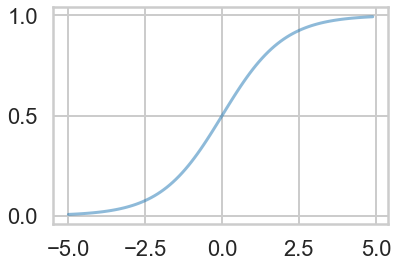

In [45]:
h = lambda z: 1. / (1 + np.exp(-z))
zs=np.arange(-5, 5, 0.1)
plt.plot(zs, h(zs), alpha=0.5);

So we then come up with our rule by identifying:

$$z = \v{w}\cdot\v{x}.$$

Then $h(\v{w}\cdot\v{x}) \ge 0.5$ if $\v{w}\cdot\v{x} \ge 0$ and $h(\v{w}\cdot\v{x}) \lt 0.5$ if $\v{w}\cdot\v{x} \lt 0$, and:

\begin{eqnarray*}
y = 1 &if& h(\v{w}\cdot\v{x}) \ge 0.5\\
y = 0 &if& h(\v{w}\cdot\v{x}) \lt 0.5.
\end{eqnarray*}

We will show soon that this identification can be achieved by minimizing a loss in the ERM framework called the **log loss** :

$$ R_{\cal{D}}(\v{w}) = - \sum_{y_i \in \cal{D}} \left ( y_i \log(h(\v{w}\cdot\v{x})) + ( 1 - y_i) \log(1 - h(\v{w}\cdot\v{x})) \right )$$

We will also add a regularization term:

$$ R_{\cal{D}}(\v{w}) = - \sum_{y_i \in \cal{D}} \left ( y_i \log(h(\v{w}\cdot\v{x})) + ( 1 - y_i) \log(1 - h(\v{w}\cdot\v{x})) \right ) + \frac{1}{C} \v{w}\cdot\v{w},$$

where $C$ is the regularization strength (equivalent to $1/\alpha$ from the Ridge case), and smaller values of $C$ mean stronger regularization. As before, the regularization tries to prevent features from having terribly high weights, thus implementing a form of feature selection. 

How did we come up with this loss? We'll come back to that, but let us see how logistic regression works out. 


In [46]:
dflog.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [47]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           dflog, ['Weight', 'Height'], 'Gender','Male')

BEST PARAMS {'C': 0.1}
Accuracy on training data: 0.92
Accuracy on test data:     0.92


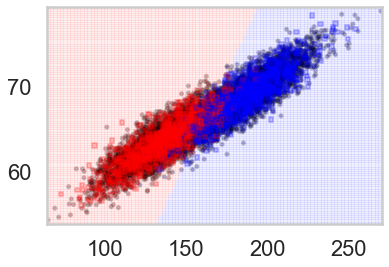

In [48]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain_l, Xtest_l, ytrain_l, ytest_l, clf_l, alpha=0.2);

In the figure here showing the results of the logistic regression, we plot the actual labels of both the training(circles) and test(squares) samples. The 0's (females) are plotted in red, the 1's (males) in blue. We also show the classification boundary, a line (to the resolution of a grid square). Every sample on the red background side of the line will be classified female, and every sample on the blue side, male. Notice that most of the samples are classified well, but there are misclassified people on both sides, as evidenced by leakage of dots or squares of one color ontothe side of the other color. Both test and traing accuracy are about 92%.

### The Probabilistic Interpretaion

Remember we said earlier that if $h > 0.5$ we ought to identify the sample with $y=1$? One way of thinking about this is to identify $h(\v{w}\cdot\v{x})$ with the probability that the sample is a '1' ($y=1$). Then we have the intuitive notion that lets identify a sample as 1 if we find that the probabilty of being a '1' is $\ge 0.5$.

So suppose we say then that the probability of $y=1$ for a given $\v{x}$ is given by $h(\v{w}\cdot\v{x})$?

Then, the conditional probabilities of $y=1$ or $y=0$ given a particular sample's features $\v{x}$ are:

\begin{eqnarray*}
P(y=1 | \v{x}) &=& h(\v{w}\cdot\v{x}) \\
P(y=0 | \v{x}) &=& 1 - h(\v{w}\cdot\v{x}).
\end{eqnarray*}

These two can be written together as

$$P(y|\v{x}, \v{w}) = h(\v{w}\cdot\v{x})^y \left(1 - h(\v{w}\cdot\v{x}) \right)^{(1-y)} $$

Then multiplying over the samples we get the probability of the training $y$ given $\v{w}$ and the $\v{x}$:

$$P(y|\v{x},\v{w}) = P(\{y_i\} | \{\v{x}_i\}, \v{w}) = \prod_{y_i \in \cal{D}} P(y_i|\v{x_i}, \v{w}) = \prod_{y_i \in \cal{D}} h(\v{w}\cdot\v{x_i})^{y_i} \left(1 - h(\v{w}\cdot\v{x_i}) \right)^{(1-y_i)}$$

Why use probabilities? Earlier, we talked about how the regression function $f(x)$ never gives us the $y$ exactly, because of noise. This hold for classification too. Even with identical features, a different sample may be classified differently. 

We said that another way to think about a noisy $y$ is to imagine that our data $\dat$ was generated from  a joint probability distribution $P(x,y)$. Thus we need to model $y$ at a given $x$, written as $P(y|x)$, and since $P(x)$ is also a probability distribution, we have:

$$P(x,y) = P(y | x) P(x)$$

and can obtain our joint probability $P(x, y)$.

Indeed its important to realize that a particular training set can be thought of as a draw from some "true" probability distribution (just as we did when showing the hairy variance diagram). If for example the probability of classifying a test sample as a '0' was 0.1, and it turns out that the test sample was a '0', it does not mean that this model was necessarily wrong. After all, in roughly a 10th of the draws, this new sample would be classified as a '0'! But, of-course its more unlikely than its likely, and having good probabilities means that we'll be likely right most of the time, which is what we want to achieve in classification. And furthermore, we can quantify this accuracy.

Thus its desirable to have probabilistic, or at the very least, ranked models of classification where you can tell which sample is more likely to be classified as a '1'. There are business reasons for this too. Consider the example of customer "churn": you are a cell-phone company and want to know, based on some of my purchasing habit and characteristic "features" if I am a likely defector. If so, you'll offer me an incentive not to defect. In this scenario, you might want to know which customers are most likely to defect, or even more precisely, which are most likely to respond to incentives. Based on these probabilities, you could then spend a finite marketing budget wisely.

### Maximizing the Probability of the Training Set

Now if we maximize $P(y|\v{x},\v{w})$, we will maximize the chance that each point is classified correctly, which is what we want to do. While this is not exactly the same thing as maximizing the 1-0 training risk, it is a principled way of obtaining the highest probability classification. This process is called **maximum likelihood** estimation since we are maximising the **likelihood of the training data y**, 

$$\like = P(y|\v{x},\v{w}).$$ 

Maximum likelihood is one of the corenerstone methods in statistics, and is used to estimate probabilities of data. 

We can equivalently maximize 

$$\loglike = \log{P(y|\v{x},\v{w})}$$ 

since the natural logarithm $\log$ is a monotonic function. This is known as maximizing the **log-likelihood**. Thus we can equivalently *minimize* a risk that is the negative of  $\log(P(y|\v{x},\v{w}))$:

$$R_{\cal{D}}(h(x)) = -\loglike = -\log \like = -\log{P(y|\v{x},\v{w})}.$$


Thus

\begin{eqnarray*}
R_{\cal{D}}(h(x)) &=& -\log\left(\prod_{y_i \in \cal{D}} h(\v{w}\cdot\v{x_i})^{y_i} \left(1 - h(\v{w}\cdot\v{x_i}) \right)^{(1-y_i)}\right)\\
                  &=& -\sum_{y_i \in \cal{D}} \log\left(h(\v{w}\cdot\v{x_i})^{y_i} \left(1 - h(\v{w}\cdot\v{x_i}) \right)^{(1-y_i)}\right)\\                  
                  &=& -\sum_{y_i \in \cal{D}} \log\,h(\v{w}\cdot\v{x_i})^{y_i} + \log\,\left(1 - h(\v{w}\cdot\v{x_i}) \right)^{(1-y_i)}\\
                  &=& - \sum_{y_i \in \cal{D}} \left ( y_i \log(h(\v{w}\cdot\v{x})) + ( 1 - y_i) \log(1 - h(\v{w}\cdot\v{x})) \right )
\end{eqnarray*}
                  
This is exactly the risk we had above, leaving out the regularization term (which we shall return to later) and was the reason we chose it over the 1-0 risk. 

Notice that this little process we carried out above tells us something very interesting: **Probabilistic estimation using maximum likelihood is equivalent to Empiricial Risk Minimization using the negative log-likelihood**, since all we did was to minimize the negative log-likelihood over the training samples.

`sklearn` will return the probabilities for our samples, or for that matter, for any input vector set $\{\v{x}_i\}$, i.e. $P(y_i | \v{x}_i, \v{w})$:

In [49]:
clf_l.predict_proba(Xtest_l)

array([[0.90242679, 0.09757321],
       [0.27484746, 0.72515254],
       [0.00233963, 0.99766037],
       ...,
       [0.31385646, 0.68614354],
       [0.00300296, 0.99699704],
       [0.84586329, 0.15413671]])

### Discriminative vs Generative Classifier

Logistic regression is what is known as a **discriminative classifier** as we learn a soft boundary between/among classes. Another paradigm is the **generative classifier** where we learn the distribution of each class. For more examples of generative classifiers, look [here](https://en.wikipedia.org/wiki/Generative_model). 

Let us plot the probabilities obtained from `predict_proba`, overlayed on the samples with their true labels:

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: UserWarning: The following kwargs were not used by contour: 'axes'
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: UserWarning: The following kwargs were not used by contour: 'axes'


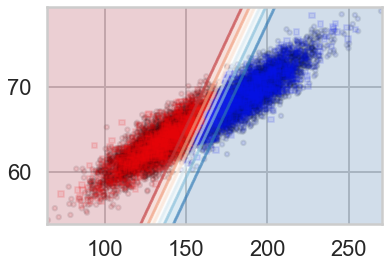

In [50]:
plt.figure()
ax = plt.gca()
points_plot_prob(ax, Xtrain_l, Xtest_l, ytrain_l, ytest_l, clf_l, psize=20, alpha=0.1);

Notice that lines of equal probability, as might be expected, are straight lines. What the classifier does is very intuitive: if the probability is greater than 0.5, it classifies the sample as type '1' (male), otherwise it classifies the sample to be class '0'. Thus in the diagram above, where we have plotted predicted values rather than actual labels of samples, there is a clear demarcation at the 0.5 probability line.

Again, this notion of trying to obtain the line or boundary of demarcation is what is called a **discriminative** classifier. The algorithm tries to find a decision boundary that separates the males from the females. To classify a new sample as male or female, it checks on which side of the decision boundary the sample falls, and makes a prediction. In other words we are asking, given $\v{x}$, what is the probability of a given $y$, or, what is the likelihood $P(y|\v{x},\v{w})$?